In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# if getting error, please mute the three lines below
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'text.usetex': True}) # import to make plots nicer
%config InlineBackend.figure_format = 'svg' # import to make plots nicer
import numpy as np
from scipy.optimize import fsolve, approx_fprime
# Set global font size
# for title, x-label, and y-label
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16


# Set global font size for x and y tick labels
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Set global font size for the legend
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
k = 35 # scaling of time

k1, k3, k2 = 9.18 ,0.12, 10
r1, r2, r4 = 2.04, 9.34, 1.84
Km1, Km2, Km3, Km4 = 0.46, 9.34, 1.26, 0.18
Dt, ACt =  1.26, 10
PDEt, Et = 9.66, 2.04



def G(u, v, J, K): # equation (4)
    numerator = 2 * u * K # numerator of the fraction
    den_1 = v - u + v * J + u * K # first part of the denominator
    den_2 = -4 * (v - u) * u * K # second part of the denominator
    radicand = den_1**2 + den_2 # expression under the square root
    denominator = den_1 + np.sqrt(radicand) # compute the entire denominator
    return numerator / denominator # compute and return the fraction


In [3]:
def f(x, param):
    cAMP, PDEp = x
    ACp = ACt*G(r1*cAMP, r2*Dt, Km1/ACt, Km2/ACt)
    dPDEp  = param * cAMP * ((PDEt - PDEp) / Km3) - r4 * Et * PDEp / (Km4 + PDEp)
    dcAMP = (k1*ACp) - (k3 + k2 * PDEp) * cAMP
    return np.array([dcAMP, dPDEp])

param_values = np.linspace(0.15, 3, 10000)

x0 = [1, 1]
epsilon = np.sqrt(np.finfo(float).eps)

equilibrium_list = []
re_part = []
im_part = []
parameter_values = []

for param in param_values:
    equilibrium = fsolve(f, x0, args=(param,))
    #print(param)

    x0 = equilibrium
    parameter_values.append(param)
    equilibrium_list.append(equilibrium)

    jacobian = np.array([approx_fprime(equilibrium, f, epsilon, param)]).reshape(2, 2)

    eigenvalues = np.linalg.eigvals(jacobian)

    re_part.append(np.real(eigenvalues))
    im_part.append(np.imag(eigenvalues))

re_part = np.array(re_part)
im_part = np.array(im_part)



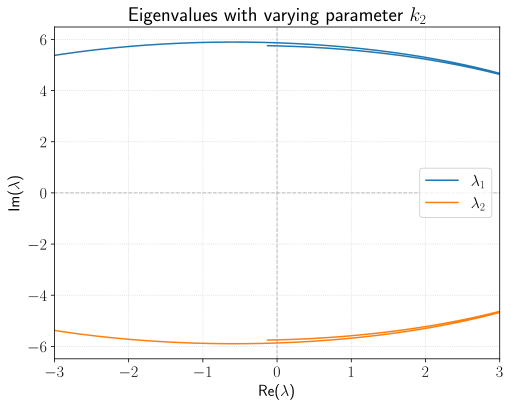

In [4]:
parameter_values = np.array(parameter_values)
plt.plot(re_part[:, 0], im_part[:, 0], label=r'$\lambda_1$')
plt.plot(re_part[:, 1], im_part[:, 1], label=r'$\lambda_2$')
plt.grid(True, linestyle=':', color='lightgray')
plt.axhline(0, color='grey', linewidth=1, linestyle='--', alpha=0.5)
plt.axvline(0, color='grey', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel(r'Re($\lambda$)')
plt.ylabel(r'Im($\lambda$)')
plt.title('Eigenvalues with varying parameter $k_2$')  #3, 3.3
plt.legend()
plt.xlim(-3, 3)
plt.savefig('evalues_corssing_im_axis_k2', dpi=300)
plt.show()

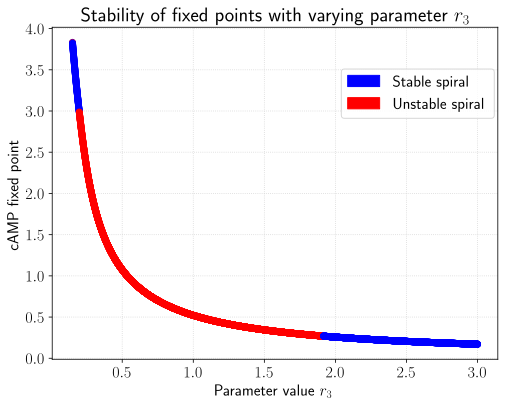

In [10]:
plt.figure()


camp_equlibrium = [eq[0] for eq in equilibrium_list]
equl_saddle = np.zeros(len(camp_equlibrium))

# list of real and imaginary parts of eigenvalues
real_parts_first_eigenvalue = [re[0] for re in re_part]
imag_parts_first_eigenvalue = [im[0] for im in im_part]
real_parts_second_eigenvalue = [re[1] for re in re_part]
imag_parts_second_eigenvalue = [im[1] for im in im_part]

colors = []
for (real1, imag1, real2, imag2) in zip(real_parts_first_eigenvalue, imag_parts_first_eigenvalue, real_parts_second_eigenvalue, imag_parts_second_eigenvalue):
    if (real1 < 0 and imag1 != 0) and (real2 < 0 and imag2 != 0):
        colors.append('b')  # Stable spiral
    elif (real1 > 0 and imag1 != 0) and (real2 > 0 and imag2 != 0):
        colors.append('r')  # Unstable spiral
    elif (real1 < 0 and imag2 == 0) and (real2 < 0 and imag2 == 0):
        colors.append('purple')  # Stable node
    elif (real1 > 0 and imag2 == 0) and (real2 > 0 and imag2 == 0):
        colors.append('y')  # Unstable node
    elif (real1 > 0 and imag1 != 0) and (real2 < 0 and imag2 != 0):
        colors.append('green')  # Saddle point
    else:
        colors.append('orange')  # Unknown
plt.grid(True, linestyle=':', color='lightgray', zorder=1)
plt.scatter(param_values, camp_equlibrium, c=colors, zorder=2)
#plt.scatter(param_values, equl_saddle, c='green', zorder=2)


import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue', label='Stable spiral', zorder=2)
red_patch = mpatches.Patch(color='red', label='Unstable spiral', zorder=2)
#green_patch = mpatches.Patch(color='green', label='Saddle point', zorder=2)
#purple_patch = mpatches.Patch(color='purple', label='Stable node', zorder=2)
#yellow_patch = mpatches.Patch(color='y', label='Unstable node', zorder=2)
plt.legend(handles=[blue_patch, red_patch], loc='right', bbox_to_anchor=(1.01, 0.8))
plt.title(r'Stability of fixed points with varying parameter $r_3$')
plt.xlabel(r'Parameter value $r_3$')
plt.ylabel('cAMP fixed point')
plt.savefig('parameter_values_vs_first_component_r3.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
# find where eigenvalue changes sign
def find_where_eigenvalue_changes(list):
    for i in range(0,len(list)):
        if list[i-1] < 0 and list[i] >=0:
            return i
        elif list[i-1] > 0 and list[i] <=0:
            return i

    return None

print(find_where_eigenvalue_changes(re_part[:, 0]))


168


In [7]:
def find_where_eigenvalue_changes(list):
    for i in range(169,len(list)):
        if list[i-1] < 0 and list[i] >=0:
            return i
        elif list[i-1] > 0 and list[i] <=0:
            return i

    return None

print(find_where_eigenvalue_changes(re_part[:, 0]))


6198


In [8]:
0 - 168 stable spiral
169 - 6198 unstable spiral
6199 - the rest is stable spiral

SyntaxError: invalid syntax (271489940.py, line 1)

In [65]:
param_values[6199]

1.916891689168917

In [68]:
re_part[6199]

array([-8.9764595e-05, -8.9764595e-05])